In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [134]:
tf.__version__

'1.12.0-rc1'

In [0]:
fs1 = 5 #filter size = 5
nf1 = 16 #no of filter = 16

fs2 = 5
nf2 = 36

fcs = 128 # fully connected size

In [136]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [0]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [0]:
img_size = 28
img_size_flat = img_size*img_size
img_shape=(img_size, img_size)
num_classes = len(data.train.labels[0])
num_channels = 1

In [0]:
def plot_img(images, cls_true, cls_pred=None):
  fig, axes = plt.subplots(3,3)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  
  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(img_shape), cmap='binary')
    
    if cls_pred is None:
      xlabel = 'True : {}'.format(cls_true[i])
    else:
      xlabel = 'True: {}, Pred: {}'.format(cls_true[i],cls_pred[i])
      
    ax.set_xlabel(xlabel)
    
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

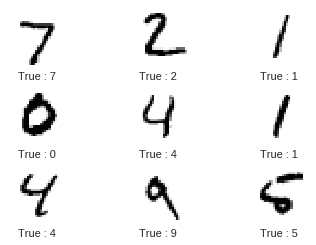

In [140]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]

plot_img(images, cls_true)

# Tensorflow Graph

In [0]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
  
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [0]:
def single_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
  shape = [filter_size, filter_size, num_input_channels, num_filters] #shape of filter/weight
  weights = new_weights(shape=shape)
  biases = new_biases(length=num_filters)
  
  layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
  layer += biases
  
  if use_pooling:
    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
  layer = tf.nn.relu(layer)
  
  return layer, weights

In [0]:
def flatten_layer(layer):
  layer_shape = layer.get_shape()
  num_features = layer_shape[1:4].num_elements()
  flat_layer = tf.reshape(layer, [-1, num_features])
  
  return flat_layer, num_features

In [0]:
def single_fc_layer(input, num_inputs, num_outputs, use_relu=True):
  weights = new_weights(shape=[num_inputs, num_outputs])
  biases = new_biases(length=num_outputs)
  
  layer = tf.matmul(input, weights) + biases
  
  if use_relu:
    layer = tf.nn.relu(layer)
    
  return layer

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])


y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)


In [0]:
convLayer1, convWeights1 = single_conv_layer(input=x_image, num_input_channels=num_channels, filter_size=fs1, num_filters=nf1, use_pooling=True)

convLayer2, convWeights2 = single_conv_layer(input=convLayer1, num_input_channels=nf1, filter_size=fs2, num_filters=nf2, use_pooling=True)

flat_layer, num_features = flatten_layer(convLayer2)

In [0]:
fcLayer1 = single_fc_layer(input=flat_layer, num_inputs=num_features, num_outputs=fcs,use_relu=True )
fcLayer2 = single_fc_layer(input=fcLayer1, num_inputs=fcs, num_outputs=num_classes, use_relu=False)

y_pred = tf.nn.softmax(fcLayer2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [0]:
# loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fcLayer2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [0]:
# optimzer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

In [0]:
#accuracy 
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Tensorflow graph run

In [0]:

session = tf.Session()
session.run(tf.global_variables_initializer())

train_batch_size = 64
test_batch_size = 256
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size=train_batch_size)
        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Iteration:{0:>6} --- Accuracy(train): {1:>6.1%}"
            print(msg.format(i, acc))
    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("\nTraining Time : " + str(timedelta(seconds=int(round(time_dif)))))
    
    
    
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_img(images=images[0:9],cls_true=cls_true[0:9],cls_pred=cls_pred[0:9])
    
    


def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    num_test = len(data.test.labels)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy(test): {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Iteration:     0 --- Accuracy(train):  23.4%
Iteration:   100 --- Accuracy(train):  57.8%
Iteration:   200 --- Accuracy(train):  81.2%
Iteration:   300 --- Accuracy(train):  84.4%
Iteration:   400 --- Accuracy(train):  95.3%
Iteration:   500 --- Accuracy(train):  90.6%
Iteration:   600 --- Accuracy(train):  89.1%
Iteration:   700 --- Accuracy(train):  84.4%
Iteration:   800 --- Accuracy(train):  98.4%
Iteration:   900 --- Accuracy(train):  87.5%

Training Time : 0:01:23
Accuracy(test): 92.8% (9283 / 10000)
Example errors:


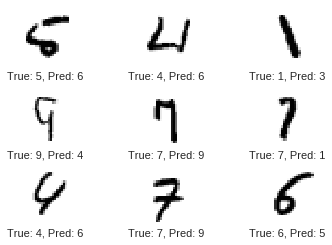

In [152]:
optimize(num_iterations=1000)
print_test_accuracy(show_example_errors=True)

Iteration:  1000 --- Accuracy(train):  92.2%
Iteration:  1100 --- Accuracy(train):  93.8%
Iteration:  1200 --- Accuracy(train): 100.0%
Iteration:  1300 --- Accuracy(train):  96.9%
Iteration:  1400 --- Accuracy(train):  85.9%
Iteration:  1500 --- Accuracy(train):  95.3%
Iteration:  1600 --- Accuracy(train):  96.9%
Iteration:  1700 --- Accuracy(train):  96.9%
Iteration:  1800 --- Accuracy(train):  93.8%
Iteration:  1900 --- Accuracy(train):  95.3%
Iteration:  2000 --- Accuracy(train):  93.8%
Iteration:  2100 --- Accuracy(train):  95.3%
Iteration:  2200 --- Accuracy(train):  96.9%
Iteration:  2300 --- Accuracy(train):  95.3%
Iteration:  2400 --- Accuracy(train):  92.2%
Iteration:  2500 --- Accuracy(train): 100.0%
Iteration:  2600 --- Accuracy(train):  92.2%
Iteration:  2700 --- Accuracy(train):  92.2%
Iteration:  2800 --- Accuracy(train):  92.2%
Iteration:  2900 --- Accuracy(train):  96.9%
Iteration:  3000 --- Accuracy(train):  98.4%
Iteration:  3100 --- Accuracy(train):  96.9%
Iteration:

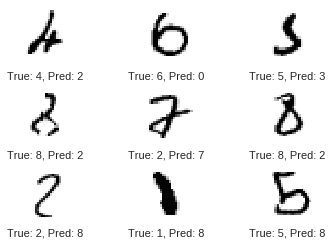

In [153]:
optimize(num_iterations=9000)
print_test_accuracy(show_example_errors=True)

In [0]:
data.validation.cls = np.array([label.argmax() for label in data.validation.labels])

def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):
    num_test = len(data.validation.labels)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.validation.images[i:j, :]
        labels = data.validation.labels[i:j, :]
        feed_dict = {x: images,y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy(test): {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)